In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import ampds_preprocessing
from tqdm import tqdm
from time import time
import pickle
%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/clusteruy/home/cmarino/miniconda3/envs/mine/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
with open('arrays/df.pickle', 'rb') as fp:
    df = pickle.load(fp)
# divide los dataframes entre agregados y desagregados
individual = df.loc[:, df.columns.get_level_values('name')!='WHE']
aggregate = df.loc[:, df.columns.get_level_values('name')=='WHE']

In [3]:
DAYS_TO_TRAIN = np.load('arrays/DAYS_TO_TRAINs.npy')
DAYS_TO_EVAL = np.load('arrays/DAYS_TO_EVAL.npy')
D = np.load('arrays/D.npy')
X = np.load('arrays/X.npy')

In [4]:
TYPE = 'simple'

In [5]:
A = np.load(f'arrays/A_{TYPE}.npy')

In [6]:
sum_current_total = X.sum(axis=0)

names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask = (individual.columns.get_level_values('name')==s)[0:A.shape[0]]

    # A enmascarado poniendo a 0 todos los coeficientes que no son del
    # electrodomestico de interes
    A_mask = A * mask[:,np.newaxis]
    serie_elec = D @ A_mask

    # Suma de corriente consumida por dia para este electrodomestico
    sum_current_elec[i] = serie_elec.sum(axis=0)

In [7]:
columns = pd.RangeIndex(715-DAYS_TO_EVAL,716)

sumas_corriente = pd.DataFrame(sum_current_elec, index=names, columns=columns)
sumas_corriente = sumas_corriente.sum(axis=1)#.rename(ampds_preprocessing.FULL_NAME)
ground_truth = individual.loc[:, 715-DAYS_TO_EVAL:715].sum(axis=0).unstack(level=0)
ground_truth = ground_truth.sum(axis=1)#.rename(ampds_preprocessing.FULL_NAME)

In [8]:
full_names = list(ampds_preprocessing.FULL_NAME.values())
full_names.remove('Whole-House Meter')
full_names = list(enumerate(full_names))
full_names = list(map(lambda x:str(x[0]+1)+'-'+x[1], full_names))

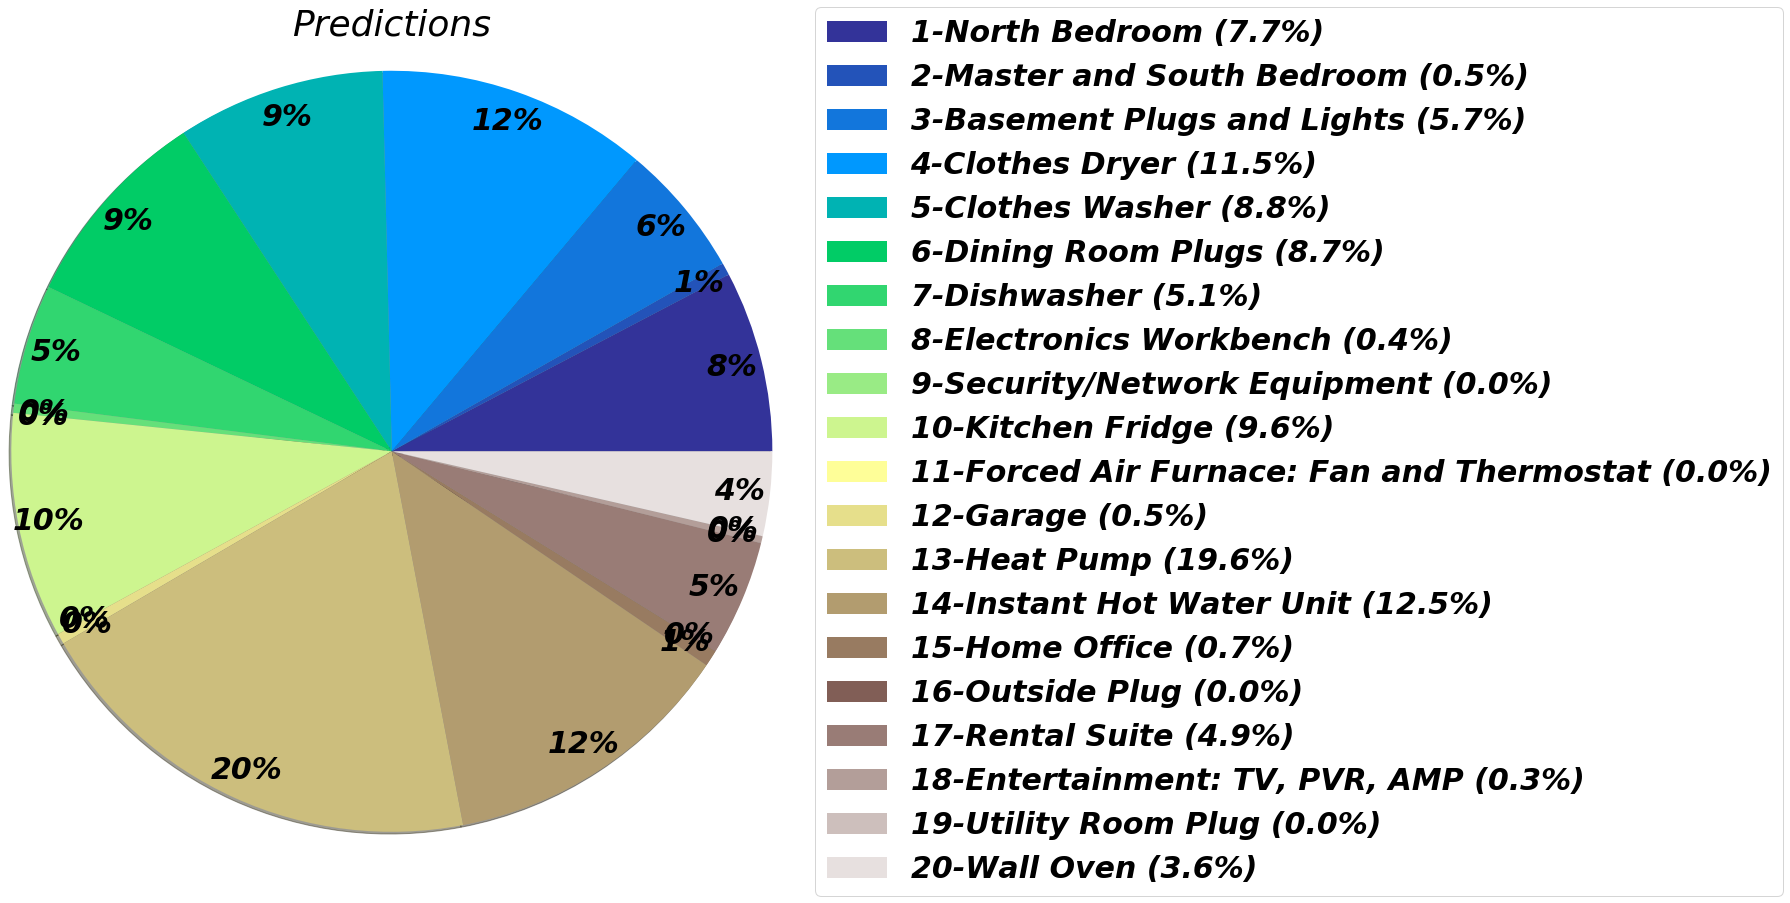

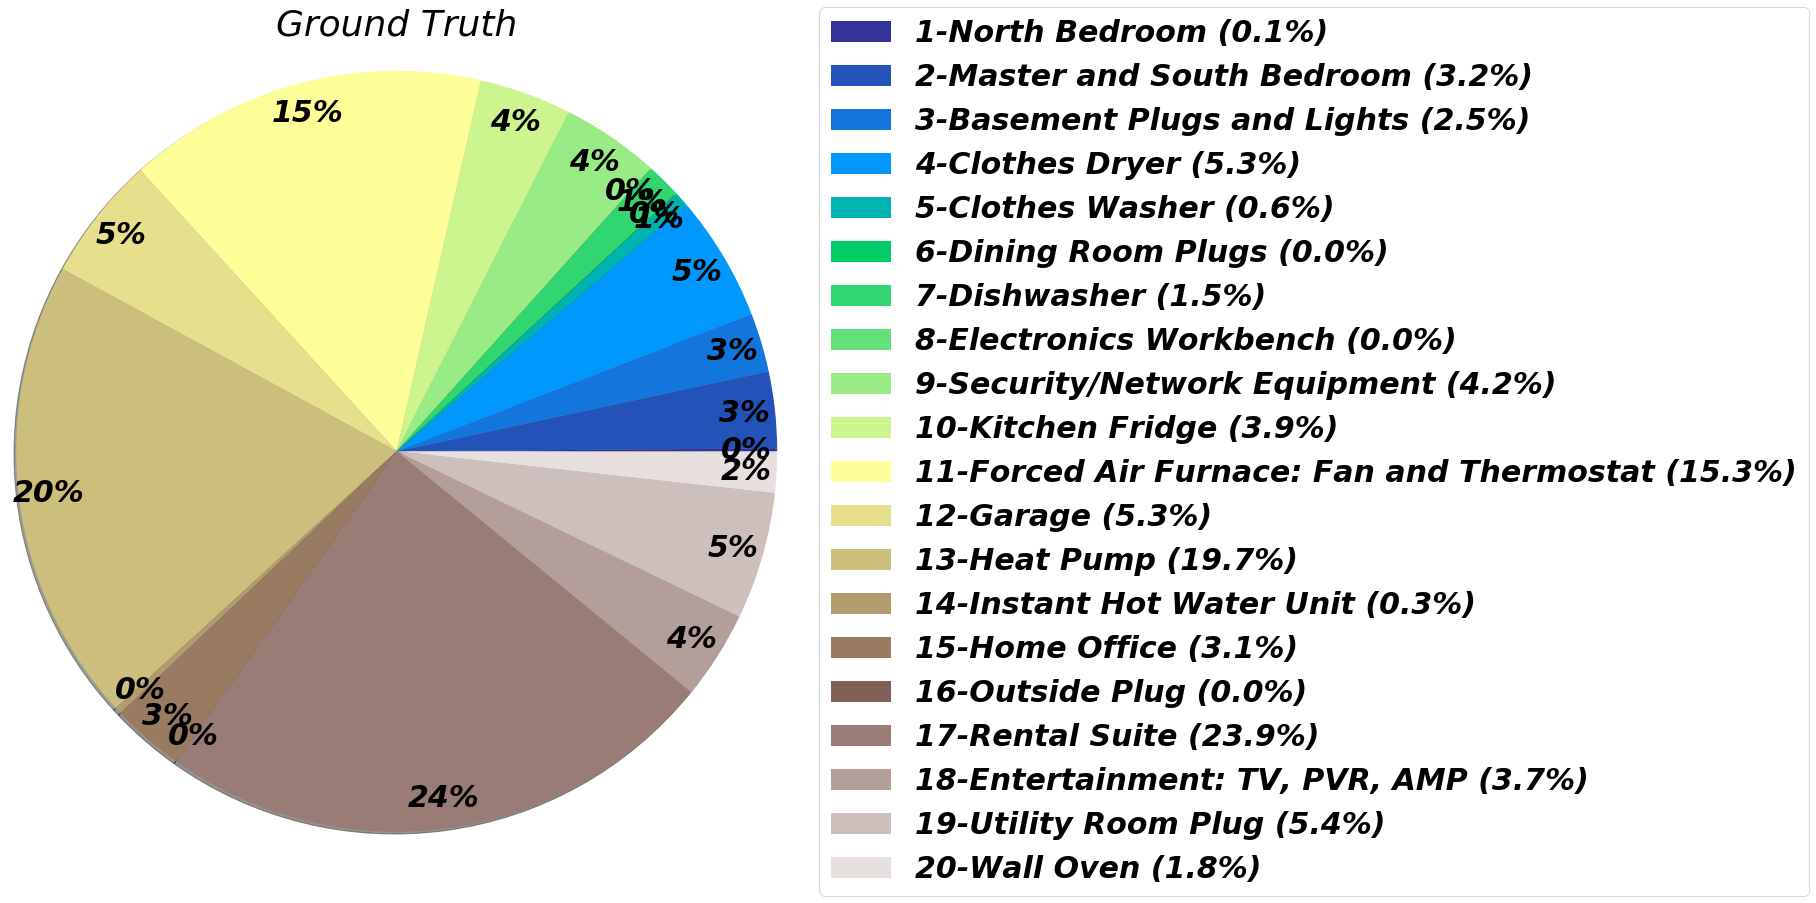

In [24]:
def add_percentege_to_names(x, full_names):
    tot = x.sum()
    percentages = list(map(lambda x:f' ({x/tot*100:.1f}%)', x))
    names = zip(full_names, percentages)
    names = list(map(lambda x:x[0]+x[1], names))
    return names

def plot_pie(x):
    rcParams['font.style'] = 'oblique'
    rcParams['font.size'] = 30
    rcParams['font.weight'] = 'heavy'

    fig1, ax1 = plt.subplots(figsize=(6, 5))

    theme = plt.get_cmap('terrain')
    ax1.set_prop_cycle("color", [theme(1. * i / len(x)) for i in range(len(x))])
    
    ax1.pie(x, 
            autopct='%1.0f%%', 
            radius=3.5, 
            shadow=True, 
            pctdistance=0.92,)
    names = add_percentege_to_names(x, full_names)
    ax1.legend(names,
               loc="center left",
               bbox_to_anchor=(2, 0, 0.5, 1))

plot_pie(sumas_corriente.to_numpy())
#plt.title('Predictions')
plt.title('Predictions', pad=(280))
plt.savefig(f'images/prediction_prob_{TYPE}.png', bbox_inches='tight')

plot_pie(ground_truth.to_numpy())
plt.title('Ground Truth', pad=(280))
plt.savefig(f'images/ground_truth_prob_{TYPE}.png', bbox_inches='tight')

In [10]:
X.shape

(1440, 136)

In [11]:
X_pred = D @ A
X_pred.shape

(1440, 136)

In [12]:
def DE(X, X_pred):
    km = np.prod(X.shape)
    de = np.sum(np.abs(X-X_pred))/km
    return de

In [13]:
f'DE = {DE(X, X_pred):.2f}'

'DE = 1.31'

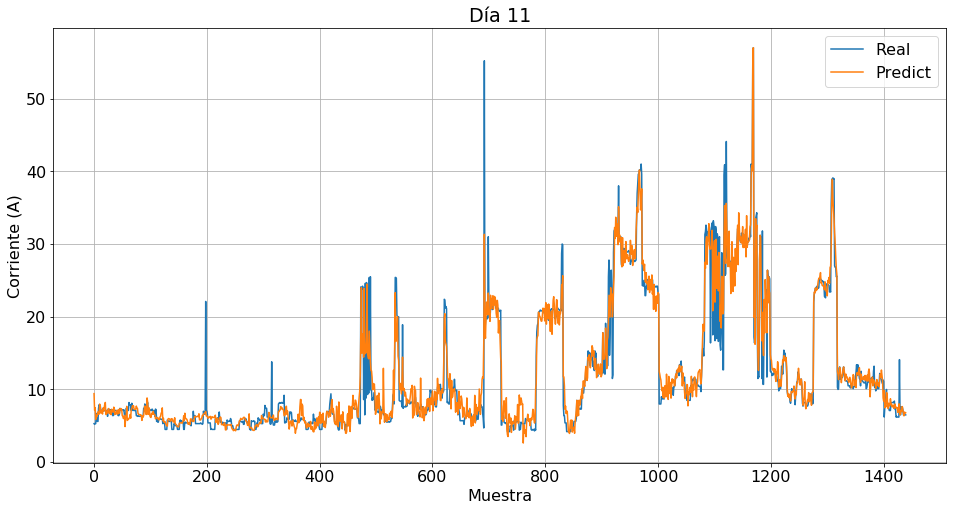

In [14]:
rcParams['font.style'] = 'normal'
rcParams['font.size'] = 16
rcParams['font.weight'] = 'normal'
dia_ejemplo = 11
plt.figure(figsize=(16, 8))
plt.plot(X[:, dia_ejemplo], label='Real')
plt.plot(X_pred[:, dia_ejemplo], label='Predict')
plt.legend()
plt.xlabel('Muestra')
plt.ylabel('Corriente (A)')
plt.grid(True)
plt.title(f'Día {dia_ejemplo}')
plt.savefig(f'images/plot_agregado_{TYPE}.png')

In [15]:
D_eval = individual.loc[:, 715-DAYS_TO_EVAL:715].to_numpy()

In [16]:
D_eval.shape

(1440, 2720)

In [17]:
X_pred.shape

(1440, 136)

In [18]:
names = list(ampds_preprocessing.FULL_NAME.keys())
names.remove('WHE')
sum_current_elec = np.empty((len(names), X.shape[1]))
mask = np.zeros(D.shape[1], dtype=int)
for i, s in enumerate(names):
    # Mascara para tener solo el electrodomestico de interes
    mask[(individual.columns.get_level_values('name')==s)[0:D.shape[1]]] = i
n_mask = len(names)

In [19]:
A.sum(axis=0).mean()

1651.868

In [20]:
for value in np.unique(mask):
    print(A[mask==value].sum(axis=0).mean(),'\t', value,
         ampds_preprocessing.FULL_NAME[names[value]])

327.18854 	 0 North Bedroom
1.2228917 	 1 Master and South Bedroom
7.610429 	 2 Basement Plugs and Lights
497.91095 	 3 Clothes Dryer
8.5029545 	 4 Clothes Washer
736.5644 	 5 Dining Room Plugs
4.128795 	 6 Dishwasher
4.0849113 	 7 Electronics Workbench
0.0 	 8 Security/Network Equipment
2.6139715 	 9 Kitchen Fridge
0.0 	 10 Forced Air Furnace: Fan and Thermostat
0.089402676 	 11 Garage
1.6942073 	 12 Heat Pump
58.54768 	 13 Instant Hot Water Unit
0.2988177 	 14 Home Office
0.27758095 	 15 Outside Plug
0.29093534 	 16 Rental Suite
0.1141043 	 17 Entertainment: TV, PVR, AMP
0.0 	 18 Utility Room Plug
0.7273233 	 19 Wall Oven


In [21]:
test = individual.loc[:, 715-DAYS_TO_EVAL:715]

In [22]:
#dish washer
rcParams['font.style'] = 'normal'
rcParams['font.size'] = 16
rcParams['font.weight'] = 'normal'
def compare(value, short_name, day=12):
    A_masked = A.copy()
    A_masked[mask!=value] = 0
    pred = D@A_masked
    real = test.loc[:, test.columns.get_level_values('name')==short_name]
    day = 12
    plt.figure(figsize=(18,4))
    plt.plot(real.iloc[:,day])
    plt.plot(pred[:,day])
    plt.xlabel('Muestra')
    plt.ylabel('Corriente (A)')
    plt.title(ampds_preprocessing.FULL_NAME[short_name])
    plt.savefig(f'images/plot_desagregado_{short_name}_{TYPE}.png')

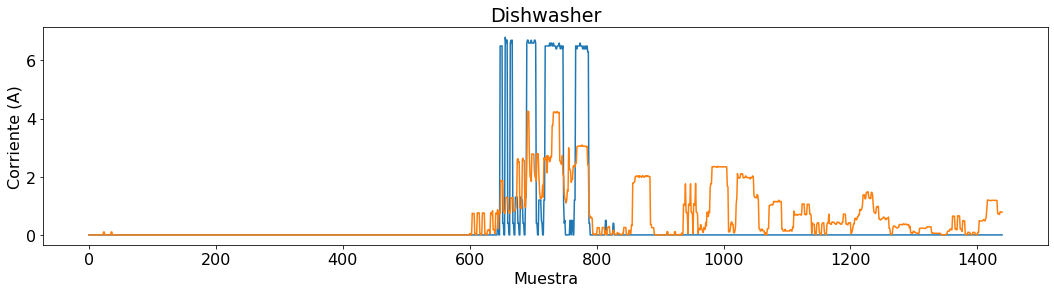

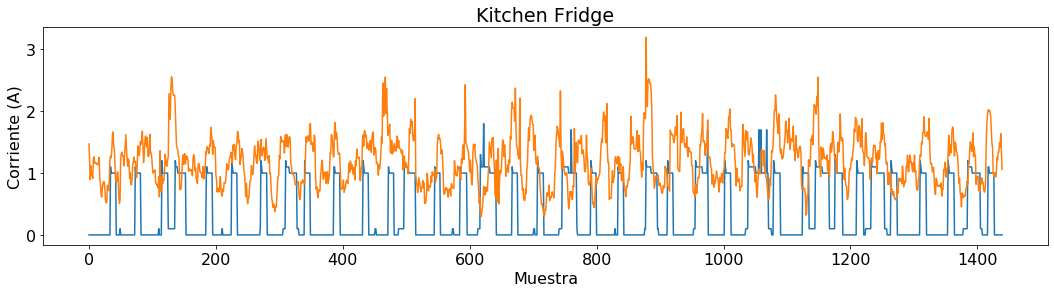

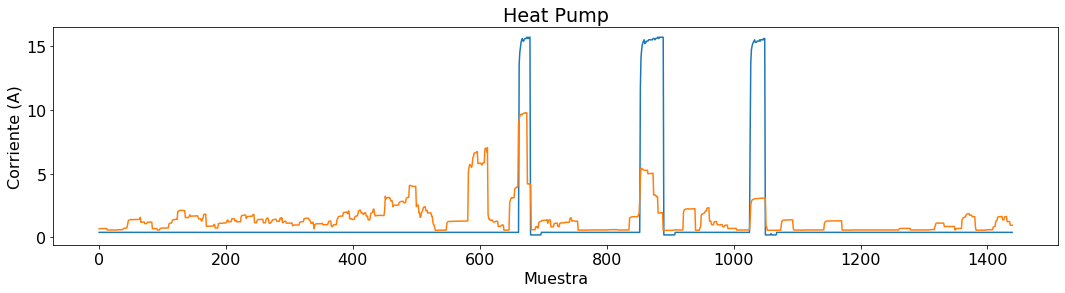

In [23]:
compare(6, 'DWE')
compare(9, 'FGE')
compare(12, 'HPE')
